# Levarage PubChem IDs for predicting the Dopamine D1 receptor antagonistsbsed on MORGAN2 features 

### Content   <a name="content"></a>

1. [Upload and analyse PubChem BioAssay AID 504652 on D1 receptor ](#1)
2. [Create a data frame with CIDs, SIDs and targets](#2)
3. [Upload and analyse PubChem BioAssay AID 1996 on water solubility ](#3)
4. [Create the final data frame, crossing the data frame that holds the targets with the water solubility data frame](#4)
5. [Ensure an equal number of classes in the test sets](#5)
6. [Scaling](#6)
7. [Balancing](#7)
8. [Machine Learning](#8)
9. [Cross validation](#9)
10. [Scrutinise for overfitting](#10)
11. [Hyperparameter tuning](#11)
12. [Final ML model](#12)
13. [Plot the learning curve ans AUC](#13)
14. [Confusion matrix](#14)
15. [Matthews Correlation Coefficient](#15)
16. [Classification report](#16)

## Upload and analyse PubChem BioAssay AID 504652 on D1 receptor <a name="1"></a>

In [1]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit import RDLogger 
from typing import List, Optional
from rdkit.Chem import AllChem
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Configuration
FP_RADIUS = 2    # Morgan Fingerprint radius. (Radius 2 = MORGAN2 = ECFP4)
FP_BITS = 1024   # The length of the output binary vector.

# Global Fix: Disable RDKit console warnings
# This line prevents "SMILES Parse Error" messages from cluttering the console.
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL) # Set level to CRITICAL to suppress INFO, WARNING, and ERROR messages

import rdkit
print(rdkit.__version__)

2023.09.5


In [2]:
# load the BioAssay PubChem AID 504652 dataset
df_targets = pd.read_csv('input/bioassy_PubChem_D1.csv', low_memory=False)

# To avoid truncation of some columns during data frame display
pd.set_option('display.max_columns', None) 

# Display the data frame
print('Shape of the data frame: ', df_targets.shape)
df_targets.head()

Shape of the data frame:  (359035, 10)


,PUBCHEM_RESULT_TAG,SID,CID,SMILES,PUBCHEM_ACTIVITY_OUTCOME,PUBCHEM_ACTIVITY_SCORE,PUBCHEM_ACTIVITY_URL,PUBCHEM_ASSAYDATA_COMMENT,Activity at 10.0 uM,Compound QC
0,1,14737807,9551164.0,C1CCC2=C(C1)C3=C(S2)N=C4C(=CC=CN4C3=O)C(=O)NCC...,Active,50,NaN,NaN,-112.471,NaN
1,2,855827,4917.0,CN1CCN(CC1)CCCN2C3=CC=CC=C3SC4=C2C=C(C=C4)Cl,Active,50,NaN,NaN,-111.528,NaN
2,3,56463488,4350931.0,CN1CCC2=CC=CC=C2CC3=C(CC1)C4=CC=CC=C4N3,Active,50,NaN,NaN,-106.814,NaN
3,4,56463458,11957685.0,CC1=CC(=CC=C1)C2CN(CCC3=C(C(=C(C=C23)O)O)Cl)C.Br,Active,50,NaN,NaN,-106.293,NaN
4,5,855962,6602611.0,C1CN(CCN1CCCN2C3=CC=CC=C3SC4=C2C=C(C=C4)C(F)(F...,Active,50,NaN,NaN,-106.287,NaN


In [3]:
df_targets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359035 entries, 0 to 359034
Data columns (total 10 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   PUBCHEM_RESULT_TAG         359035 non-null  int64  
 1   SID                        359035 non-null  int64  
 2   CID                        359034 non-null  float64
 3   SMILES                     359034 non-null  object 
 4   PUBCHEM_ACTIVITY_OUTCOME   359035 non-null  object 
 5   PUBCHEM_ACTIVITY_SCORE     359035 non-null  int64  
 6   PUBCHEM_ACTIVITY_URL       0 non-null       float64
 7   PUBCHEM_ASSAYDATA_COMMENT  0 non-null       float64
 8   Activity at 10.0 uM        359035 non-null  float64
 9   Compound QC                0 non-null       float64
dtypes: float64(5), int64(3), object(2)
memory usage: 27.4+ MB


In [4]:
# Remove duplicates 
df_targets.drop_duplicates()
df_targets.shape  # 353737 means no duplicates

(359035, 10)

In [5]:
# Remove compounds with missing CID-s
df_targets = df_targets[df_targets['CID'].notna()]
df_targets.shape

(359034, 10)

In [6]:
# Remove compounds with missing SID-s
df_targets = df_targets[df_targets['SID'].notna()]
df_targets.shape

(359034, 10)

In [7]:
import numpy as np
# Turn CID float data type into integer
df_targets['CID'] = df_targets['CID'].astype(np.int64) 
df_targets.info()

<class 'pandas.core.frame.DataFrame'>
Index: 359034 entries, 0 to 359034
Data columns (total 10 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   PUBCHEM_RESULT_TAG         359034 non-null  int64  
 1   SID                        359034 non-null  int64  
 2   CID                        359034 non-null  int64  
 3   SMILES                     359034 non-null  object 
 4   PUBCHEM_ACTIVITY_OUTCOME   359034 non-null  object 
 5   PUBCHEM_ACTIVITY_SCORE     359034 non-null  int64  
 6   PUBCHEM_ACTIVITY_URL       0 non-null       float64
 7   PUBCHEM_ASSAYDATA_COMMENT  0 non-null       float64
 8   Activity at 10.0 uM        359034 non-null  float64
 9   Compound QC                0 non-null       float64
dtypes: float64(4), int64(4), object(2)
memory usage: 30.1+ MB


In [8]:
df_targets.rename(columns={'PUBCHEM_ACTIVITY_OUTCOME': 'target'}, inplace=True)

[<a href="#content">Back to top</a>]

## Create a data frame with CIDs, SIDs and targets <a name="2"></a>

In [9]:
# Create a data frame containing the classification targets
df_targets = df_targets [['CID', 'SID', 'SMILES', 'target']]

# Display the data frame
print('Shape of df_targets : ', df_targets .shape)
df_targets .head()

Shape of df_targets :  (359034, 4)


,CID,SID,SMILES,target
0,9551164,14737807,C1CCC2=C(C1)C3=C(S2)N=C4C(=CC=CN4C3=O)C(=O)NCC...,Active
1,4917,855827,CN1CCN(CC1)CCCN2C3=CC=CC=C3SC4=C2C=C(C=C4)Cl,Active
2,4350931,56463488,CN1CCC2=CC=CC=C2CC3=C(CC1)C4=CC=CC=C4N3,Active
3,11957685,56463458,CC1=CC(=CC=C1)C2CN(CCC3=C(C(=C(C=C23)O)O)Cl)C.Br,Active
4,6602611,855962,C1CN(CCN1CCCN2C3=CC=CC=C3SC4=C2C=C(C=C4)C(F)(F...,Active


In [10]:
# Check the classes in the bioassay
df_targets['target'].value_counts()

target
Inactive    347568
Active       11466
Name: count, dtype: int64

In [11]:
# Remove the Inconclusive samples 
df_targets = df_targets[df_targets['target']!='Inconclusive']
df_targets['target'].value_counts()

target
Inactive    347568
Active       11466
Name: count, dtype: int64

In [12]:
# Set the binary targets to "1" for an active antagonist and "0" for inactive 
df_targets = df_targets.copy()

# Create a dictionary
targets = {'Active' : 1,
           'Inactive' : 0}

# Replace the names with binary values set up in the dictionary targets
df_targets.target = [targets[item] for item in df_targets.target]

# Check how many unique values there are in the 'target' column
print('Unique values: ', df_targets['target'].unique())

# Count each of the binary targets
df_targets['target'].value_counts()

Unique values:  [1 0]


target
0    347568
1     11466
Name: count, dtype: int64

In [13]:
# Display the data frame
print('Shape of the df_targets: ', df_targets.shape)
df_targets.head()

Shape of the df_targets:  (359034, 4)


,CID,SID,SMILES,target
0,9551164,14737807,C1CCC2=C(C1)C3=C(S2)N=C4C(=CC=CN4C3=O)C(=O)NCC...,1
1,4917,855827,CN1CCN(CC1)CCCN2C3=CC=CC=C3SC4=C2C=C(C=C4)Cl,1
2,4350931,56463488,CN1CCC2=CC=CC=C2CC3=C(CC1)C4=CC=CC=C4N3,1
3,11957685,56463458,CC1=CC(=CC=C1)C2CN(CCC3=C(C(=C(C=C23)O)O)Cl)C.Br,1
4,6602611,855962,C1CN(CCN1CCCN2C3=CC=CC=C3SC4=C2C=C(C=C4)C(F)(F...,1


In [14]:
# Creat a dataframe with full set of target 1 for latter use
df_targets_1 = df_targets[df_targets['target']==1]

[<a href="#content">Back to top</a>]

## Upload and analyse PubChem BioAssay AID 1996 on water solubility <a name="3"></a>

In [15]:
# Load data from PubChem BioAssay AID 1996 
df_solubility = pd.read_csv('input/pubchem_solubility.csv')

# Display the data frame
print('Shape of df_solubility: ', df_solubility.shape)
df_solubility.head()

Shape of df_solubility:  (57859, 30)


,PUBCHEM_RESULT_TAG,SID,CID,PUBCHEM_EXT_DATASOURCE_SMILES,OUTCOME,PUBCHEM_ACTIVITY_SCORE,PUBCHEM_ACTIVITY_URL,PUBCHEM_ASSAYDATA_COMMENT,Solubility at pH 7.4_Qualifier_Mean,Solubility at pH 7.4_Mean,Test Concentration_1,Solubility at pH 7.4_Qualifier_1,Solubility at pH 7.4_1,Solubility at pH 7.4_Comment_1,Solubility of Astemizole at pH 7.4_Qualifier_1,Solubility of Astemizole at pH 7.4_1,Solubility of Sulfamethizole at pH 7.4_Qualifier_1,Solubility of Sulfamethizole at pH 7.4_1,Solubility of Imipramine HCl at pH 7.4_Qualifier_1,Solubility of Imipramine HCl at pH 7.4_1,Test Concentration_2,Solubility at pH 7.4_Qualifier_2,Solubility at pH 7.4_2,Solubility at pH 7.4_Comment_2,Solubility of Astemizole at pH 7.4_Qualifier_2,Solubility of Astemizole at pH 7.4_2,Solubility of Sulfamethizole at pH 7.4_Qualifier_2,Solubility of Sulfamethizole at pH 7.4_2,Solubility of Imipramine HCl at pH 7.4_Qualifier_2,Solubility of Imipramine HCl at pH 7.4_2
0,1,24826444,2374148,COC1=CC=C(C=C1)OCC2=NNC(=S)N2N,Active,40,NaN,NaN,=,10.85,200,<,0.1,Below LOQ,=,14.2,>,40.5,>,47.5,200.0,=,21.6,NaN,=,27.7,>,40.5,>,47.5
1,2,49669186,5295761,CC1=CC(=C(C=C1)NC2=NC3=CC=CC=C3N4C2=NN=C4)Cl,Inactive,0,NaN,NaN,<,0.10,200,<,0.1,Below LOQ,=,12.3,>,40.5,>,47.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,49669768,22431387,CC1=CC(=CC=C1)CCNC2=NC3=C(C=C(C=C3)C)N4C2=NN=C4,Inactive,0,NaN,NaN,<,0.10,200,<,0.1,Below LOQ,=,12.3,>,40.5,>,47.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,8139962,14296,CC1=C(N=C(C(=N1)C)C)C,Inactive,0,NaN,NaN,<,0.10,200,<,0.1,Below LOQ,=,11.4,>,40.5,>,47.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,24803435,865684,CC1=CC2=NC(=C(C=C2C=C1)C#N)NC3=CC=CC=C3OC,Inactive,0,NaN,NaN,<,0.20,200,<,0.2,Below LOQ,=,11.4,>,40.5,>,47.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
df_solubility.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57859 entries, 0 to 57858
Data columns (total 30 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   PUBCHEM_RESULT_TAG                                  57859 non-null  int64  
 1   SID                                                 57859 non-null  int64  
 2   CID                                                 57859 non-null  int64  
 3   PUBCHEM_EXT_DATASOURCE_SMILES                       57859 non-null  object 
 4   OUTCOME                                             57859 non-null  object 
 5   PUBCHEM_ACTIVITY_SCORE                              57859 non-null  int64  
 6   PUBCHEM_ACTIVITY_URL                                0 non-null      float64
 7   PUBCHEM_ASSAYDATA_COMMENT                           0 non-null      float64
 8   Solubility at pH 7.4_Qualifier_Mean                 57859 non-null  object 


In [17]:
# Create the desired data frame with CID and SID for sifting 
df_solubility = df_solubility[['SID', 'CID']]

# Display the data frame
print('Shape of the data frame: ', df_solubility.shape)
df_solubility.head()

Shape of the data frame:  (57859, 2)


,SID,CID
0,24826444,2374148
1,49669186,5295761
2,49669768,22431387
3,8139962,14296
4,24803435,865684


[<a href="#content">Back to top</a>]

## Create the final data frame, crossing the data frame that holds the targets with the water solubility data frame  <a name="4"></a>

In [18]:
# Sift the main data frame with targets using the solubility data frame 
df = pd.merge(df_targets, df_solubility, on=["CID", "SID"])

# Display the data frame
print('Shape of the data frame: ', df.shape)
df.head()

Shape of the data frame:  (49968, 4)


,CID,SID,SMILES,target
0,91499,56422461,CN1CCN(CC1)CCCN2C3=CC=CC=C3SC4=C2C=C(C=C4)Cl.C...,1
1,2331,11532898,C1=CC=C(C=C1)C(=O)N,1
2,7207402,24815591,CC1=CSC(=N1)NC(=O)CSC2=NN=C(C=C2)C3=CC=CC=N3,1
3,1480768,49666136,CC1=CC=C(C=C1)C2=CC3=CC=CC=C3N=C2N,1
4,2813126,26730947,CC1=CC(=O)OC2=C1C=CC(=C2)NS(=O)(=O)C3=CC=CC=C3,1


In [19]:
# Count values of the sifted data frame 
df['target'].value_counts()

target
0    48596
1     1372
Name: count, dtype: int64

In [20]:
# Create a data frame with target 0
df_0 = df[df['target']==0]

# Concatenate the sifted target 0 with the original target 1
df = pd.concat([df_0, df_targets_1])

df.to_csv("HF_dopamine_D1_receptor_antagonists_CID_SID.csv", index=False)
# Display the data frame
print('Shape of the data frame: ', df.shape)
df.head()

Shape of the data frame:  (60062, 4)


,CID,SID,SMILES,target
1372,2176767,49645228,C1=CC=C(C=C1)CCNC(=O)C(=O)C2=CNC3=CC=CC=C32,0
1373,2134766,24827624,CC(=O)CC1=NSC(=N1)NC(=O)C2=CC=CC=C2Cl,0
1374,802924,49678206,CC1=CC(=C(C=C1)NC(=S)C2=CC=NC=C2)C,0
1375,4214295,57264924,CC(C(=O)NC1CCCC1)SC2=NN=NN2C3=CC=C(C=C3)OC,0
1376,3222855,24809416,C1CCC(CC1)NC(=O)N2CCCC(C2)C(=O)NC3CC3,0


In [21]:
# Count the target
df['target'].value_counts()

target
0    48596
1    11466
Name: count, dtype: int64

In [22]:
# Shuffle the resulting data set
df = df.sample(
    frac = 1,        # Return entire dataframe
    random_state=1   # Make result reproducible
    ).reset_index(drop=True)

In [23]:
# Handle the part of target 1 in the test set 
df_1 = df[df['target']==1]

# Shuffle the resulting data set
df_1 = df_1.sample(
    frac = 1,        # Return entire dataframe
    random_state=1   # Make result reproducible
    ).reset_index(drop=True)


In [24]:
# Handle the part of target 0 in the test set 
df_0 = df[df['target']==0]

# Shuffle the resulting data set
df_0 = df_0.sample(
    frac = 1,        # Return entire dataframe
    random_state=1   # Make result reproducible
    ).reset_index(drop=True)

# Extract every nth row (e.g., every 4th row)
n = 3
df_0 = df_0[df_0.index % n == 0] 

# Shuffle the resulting data set
df_0 = df_0.sample(
    frac = 1,        # Return entire dataframe
    random_state=1   # Make result reproducible
    ).reset_index(drop=True)


In [25]:
# Create train and test dataframe for further manipulation 
df = pd.concat([df_0, df_1])

[<a href="#content">Back to top</a>]

## Create the MORGAN2 RDkit features <a name="2"></a>

In [26]:
import time

# Record the start time
start_time = time.time()

In [27]:
# Create a variable smiles
smiles = df['SMILES']

def smiles_to_morgan2_array(smiles: str, radius: int = FP_RADIUS, n_bits: int = FP_BITS) -> Optional[np.ndarray]:
    """
    Generates a single Morgan fingerprint (as a NumPy array) from a SMILES string.
    Returns None if the SMILES is invalid.
    """
    try:
        # Note: Chem.MolFromSmiles will return None for invalid SMILES, 
        # but the logging is now suppressed by the global setting above.
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None
            
        # 1. Generate the Morgan Fingerprint BitVect
        # Morgan (radius=2) is the RDKit implementation of ECFP4.
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=n_bits)
        
        # 2. Convert the BitVect to a 1D NumPy array
        fp_array = np.array(fp, dtype=np.int8)
        return fp_array
    except Exception as e:
        # Catch any other Python errors and print them if they occur
        print(f"Internal processing error for SMILES '{smiles}': {e}")
        return None
def process_dataframe_to_features(df: pd.DataFrame, smiles_column: str) -> Optional[np.ndarray]:
    """
    Applies the Morgan fingerprint generation across the DataFrame.
    """
    print(f"Starting feature generation for {len(df)} molecules...")
    
    # Apply the function to the SMILES column
    fingerprint_series = df[smiles_column].apply(smiles_to_morgan2_array)
    
    # Filter out rows where fingerprint generation failed (invalid SMILES)
    valid_fingerprints = fingerprint_series.dropna().tolist()
    
    invalid_count = len(df) - len(valid_fingerprints)
    if invalid_count > 0:
        print(f"Warning: Dropped {invalid_count} row(s) due to invalid SMILES.")
    
    if not valid_fingerprints:
        print("Error: No valid fingerprints generated.")
        return None
    
    # Stack all 1D arrays into a single 2D NumPy feature matrix (X)
    X_features = np.vstack(valid_fingerprints)
    
    return X_features
# Generate MORGAN2 Features 
X_morgan2 = process_dataframe_to_features(df, smiles_column='SMILES')

# Prepare Targets (y) 
# We must ensure that the target vector (y) only contains labels for the *valid* molecules.
valid_mask = df['SMILES'].apply(lambda x: Chem.MolFromSmiles(x) is not None)
y_targets = df[valid_mask]['target'].values

# Final Output
if X_morgan2 is not None:
    print("\n--- Final Output Ready for ML ---")
    print(f"X_features (MORGAN2) shape: {X_morgan2.shape}")
    print(f"y_targets shape: {y_targets.shape}")
    print("\nFirst 3 rows of the MORGAN2 feature matrix (X) (first 15 bits):")
    print(X_morgan2[:3, :15])

Starting feature generation for 27665 molecules...

--- Final Output Ready for ML ---
X_features (MORGAN2) shape: (27665, 1024)
y_targets shape: (27665,)

First 3 rows of the MORGAN2 feature matrix (X) (first 15 bits):
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]]


[<a href="#content">Back to top</a>]

## Data preperation for Machine learning <a name="3"></a>

In [28]:
# Split Data for Training and Testing
X_train, X_test, y_train, y_test = train_test_split(
    X_morgan2, 
    y_targets, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_targets
)

print("\n--- ML Data Split Summary ---")
print(f"Training Samples: {len(X_train)}")
print(f"Testing Samples: {len(X_test)}")
print("Data is now ready for model training")


--- ML Data Split Summary ---
Training Samples: 22132
Testing Samples: 5533
Data is now ready for model training


In [29]:
# # Keeping sets for the cross validation  
X_cv = X_train
y_cv = y_train

In [30]:
from sklearn.preprocessing import StandardScaler

# Standardise the data points
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [31]:
# Print the shape of each part
print("Shapes:")
print("X_train: ", X_train.shape)
print("X_test:  ", X_test.shape)
print("y_train: ", y_train.shape)
print("y_test:  ", y_test.shape)

Shapes:
X_train:  (22132, 1024)
X_test:   (5533, 1024)
y_train:  (22132,)
y_test:   (5533,)


[<a href="#content">Back to top</a>]

## Balancing <a name="7"></a>

[(0, 12959), (1, 9173)]


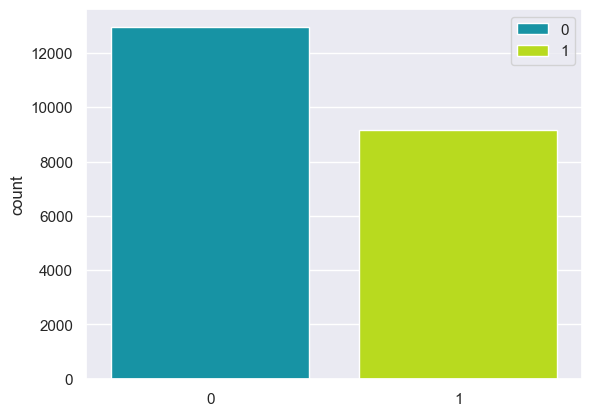

In [32]:
from collections import Counter
from matplotlib import pyplot as plt
import seaborn as sns

# Plot the imbalance between the targets 
print(sorted(Counter(y_train).items()))
sns.set_style('white')
sns.set(font_scale=1)
plt.figure()
sns.countplot(x=y_train, hue=y_train, palette='nipy_spectral')
plt.show()

[(0, 12959), (1, 12959)]


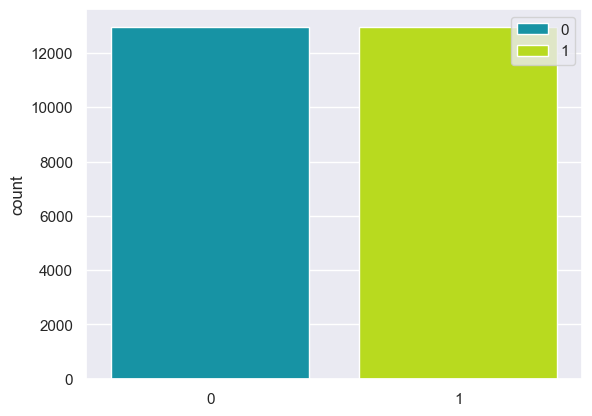

In [33]:
# from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler

# Balance targets with Synthetic Minority Oversampling Technique
# smote = SMOTE(random_state=0)
ros = RandomOverSampler()

X_train, y_train = ros.fit_resample(X_train, y_train)

# Plot the balance between classification targets 
print(sorted(Counter(y_train).items()))
sns.set_style('white')
sns.set(font_scale=1)
plt.figure()
sns.countplot(x=y_train, hue=y_train,palette='nipy_spectral')
plt.show()

In [34]:
# Print the shape of each part
print("Shapes:")
print("X_train: ", X_train.shape)
print("X_test:  ", X_test.shape)
print("y_train: ", y_train.shape)
print("y_test:  ", y_test.shape)

Shapes:
X_train:  (25918, 1024)
X_test:   (5533, 1024)
y_train:  (25918,)
y_test:   (5533,)


[<a href="#content">Back to top</a>]

## Machine Learning <a name="8"></a>

In [35]:
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score
import matplotlib.pyplot as plt

# Instantiate the estimator 
model = XGBClassifier(random_state=42)

# Train  
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluation
acc = round(accuracy_score(y_test, y_pred),3)
print('Accuracy: ', acc)
pre = round(precision_score(y_test, y_pred),3)
print('Precision: ', pre) 
rec = round(recall_score(y_test, y_pred),3)
print('Recall: ',rec) 
f1 = round(f1_score(y_test, y_pred),3)
print('F1: ', f1) 
roc = round(roc_auc_score(y_test, y_pred),3) 
print('ROC: ', roc)

Accuracy:  0.733
Precision:  0.696
Recall:  0.634
F1:  0.663
ROC:  0.719


In [36]:
# Record the end time
end_time = time.time()

# Calculate and print the elapsed time
elapsed_time = end_time - start_time
print(f"Time elapsed: {elapsed_time:.4f} seconds")

Time elapsed: 37.6705 seconds


[<a href="#content">Back to top</a>]

## Cross-validation  <a name="9"></a>

In [37]:
# Five-fold cross-validation
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix 

# Define the Model
model = XGBClassifier(random_state=42)

# Number of folds
n_splits = 5

# Stratified K-Fold ensures balanced class distribution in each fold
# This ensures that each training and test fold has a similar percentage of class 1.
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Lists to store metrics from each fold
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
roc_auc_scores = []

# --- 3. Cross-Validation Loop with Manual SMOTE Resampling ---
print(f"Performing {n_splits}-Fold Stratified Cross-Validation with Manual SMOTE...\n")

# Initialize the SMOTE object once
# smote= SMOTE(random_state=42)

for fold, (train_index, test_index) in enumerate(skf.split(X_cv, y_cv)):
    print(f"--- Fold {fold + 1}/{n_splits} ---")

    # Split data for the current fold
    X_train_cv, X_test_cv = X_cv[train_index], X_cv[test_index]
    y_train_cv, y_test_cv = y_cv[train_index], y_cv[test_index]

    # Report class distributions before resampling
    print(f"  Training set class distribution (Original): {np.bincount(y_train_cv)}")
    print(f"  Test set class distribution: {np.bincount(y_test_cv)}")

    # Apply SMOTE oversampling on the training split only
    # This is the step that replaces the imblearn pipeline logic.
    X_train_resampled, y_train_resampled = ros.fit_resample(X_train_cv, y_train_cv)
    print(f"  Training set (after SMOTE) class distribution: {np.bincount(y_train_resampled)}")

    # Train the model on the resampled training data
    model.fit(X_train_resampled, y_train_resampled)

    # Make predictions on the *original, untouched* test data
    y_pred_cv = model.predict(X_test_cv)
    # Get probabilities for ROC AUC calculation
    y_prob_cv = model.predict_proba(X_test_cv)[:, 1]

    # Evaluate performance for the current fold
    accuracy = accuracy_score(y_test_cv, y_pred_cv)
    precision = precision_score(y_test_cv, y_pred_cv, zero_division=0)
    recall = recall_score(y_test_cv, y_pred_cv, zero_division=0)
    f1 = f1_score(y_test_cv, y_pred_cv, zero_division=0)
    roc_auc = roc_auc_score(y_test_cv, y_prob_cv)

    # Store scores
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    roc_auc_scores.append(roc_auc)

    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall (Sensitivity): {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    print(f"  ROC AUC: {roc_auc:.4f}")
    print(f"  Confusion Matrix:\n{confusion_matrix(y_test_cv, y_pred_cv)}\n")
    print("-" * 30)


# --- 4. Aggregate and Report Final Metrics ---
print("\n--- Cross-Validation Results Summary ---")

# Convert lists to NumPy arrays for easier statistical manipulation
accuracy_scores = np.array(accuracy_scores)
precision_scores = np.array(precision_scores)
recall_scores = np.array(recall_scores)
f1_scores = np.array(f1_scores)
roc_auc_scores = np.array(roc_auc_scores)

print(f"Average Accuracy: {np.mean(accuracy_scores):.4f} +/- {np.std(accuracy_scores):.4f}")
print(f"Average Precision: {np.mean(precision_scores):.4f} +/- {np.std(precision_scores):.4f}")
print(f"Average Recall: {np.mean(recall_scores):.4f} +/- {np.std(recall_scores):.4f}")
print(f"Average F1-Score: {np.mean(f1_scores):.4f} +/- {np.std(f1_scores):.4f}")
print(f"Average ROC AUC: {np.mean(roc_auc_scores):.4f} +/- {np.std(roc_auc_scores):.4f}")
print("\n--- Summary ---")
print("The standard deviation (+/-) indicates the stability of the model performance across the different folds.")

Performing 5-Fold Stratified Cross-Validation with Manual SMOTE...

--- Fold 1/5 ---
  Training set class distribution (Original): [10367  7338]
  Test set class distribution: [2592 1835]
  Training set (after SMOTE) class distribution: [10367 10367]
  Accuracy: 0.7183
  Precision: 0.6727
  Recall (Sensitivity): 0.6240
  F1-Score: 0.6474
  ROC AUC: 0.7679
  Confusion Matrix:
[[2035  557]
 [ 690 1145]]

------------------------------
--- Fold 2/5 ---
  Training set class distribution (Original): [10367  7338]
  Test set class distribution: [2592 1835]
  Training set (after SMOTE) class distribution: [10367 10367]
  Accuracy: 0.7260
  Precision: 0.6779
  Recall (Sensitivity): 0.6458
  F1-Score: 0.6615
  ROC AUC: 0.7830
  Confusion Matrix:
[[2029  563]
 [ 650 1185]]

------------------------------
--- Fold 3/5 ---
  Training set class distribution (Original): [10368  7338]
  Test set class distribution: [2591 1835]
  Training set (after SMOTE) class distribution: [10368 10368]
  Accuracy:

[<a href="#content">Back to top</a>]

## Scrutinise for overfitting  <a name="10"></a>

In [38]:
# Evaluate XGBClassifier performance on train and test sets with different tree depths
train_scores, test_scores = list(), list()
# define the tree depths to evaluate
values = [i for i in range(1, 21)]
# evaluate a decision tree for each depth
for i in values:
 # configure the model
 model_ = XGBClassifier(max_depth=i)
 # fit model_ on the training dataset
 model_.fit(X_train, y_train)
 # evaluate on the train dataset
 train_yhat = model_.predict(X_train)
 train_acc = accuracy_score(y_train, train_yhat)
 train_scores.append(train_acc)
 # evaluate on the test dataset
 test_yhat = model_.predict(X_test)
 test_acc = accuracy_score(y_test, test_yhat)
 test_scores.append(test_acc)
 # summarize progress
 print('>%d, train: %.3f, test: %.3f' % (i, train_acc, test_acc))

>1, train: 0.681, test: 0.670
>2, train: 0.719, test: 0.700
>3, train: 0.758, test: 0.714
>4, train: 0.800, test: 0.721
>5, train: 0.839, test: 0.722
>6, train: 0.879, test: 0.733
>7, train: 0.914, test: 0.728
>8, train: 0.938, test: 0.731
>9, train: 0.958, test: 0.734
>10, train: 0.969, test: 0.738
>11, train: 0.979, test: 0.730
>12, train: 0.986, test: 0.734
>13, train: 0.991, test: 0.733
>14, train: 0.995, test: 0.728
>15, train: 0.996, test: 0.737
>16, train: 0.997, test: 0.732
>17, train: 0.998, test: 0.730
>18, train: 0.999, test: 0.736
>19, train: 0.999, test: 0.736
>20, train: 0.999, test: 0.740


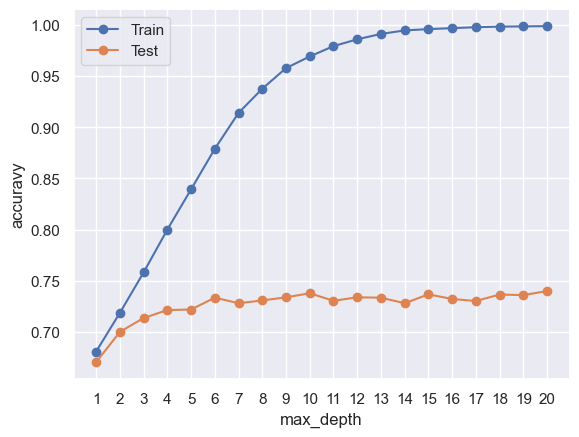

In [39]:
import math

# Set integers for x axis
new_x_ticks = range(math.floor(min(values)), math.ceil(max(values))+1)
plt.xticks(new_x_ticks)
# Plot of train and test scores vs tree depth
plt.plot(values, train_scores, '-o', label='Train')
plt.plot(values, test_scores, '-o', label='Test')
plt.legend()
plt.xlabel("max_depth")
plt.ylabel("accuravy")
plt.show()

[<a href="#content">Back to top</a>]

## Hyperparameter tuning  <a name="11"></a>

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'max_depth': [3],
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Create the model
model = XGBClassifier()

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, 
                          cv=5, scoring='accuracy', verbose=2) 
grid_search.fit(X_train, y_train) 

# Print the best parameters and score
print(grid_search.best_params_)
print(grid_search.best_score_)

In [ ]:
# Evaluate XGBClassifier on train and test sets with different tree depths
train_scores, test_scores = list(), list()
# define the tree depths to evaluate
values = [i for i in range(1, 21)]
# evaluate a decision tree for each depth
for i in values:
 # configure the model
 model_= XGBClassifier(max_depth=i,
                       colsample_bytree=1.0,
                       learning_rate=0.3,
                       n_estimators=300,
                       subsample=1.0)
 # fit model_ on the training dataset
 model_.fit(X_train, y_train)
 # evaluate on the train dataset
 train_yhat = model_.predict(X_train)
 train_acc = accuracy_score(y_train, train_yhat)
 train_scores.append(train_acc)
 # evaluate on the test dataset
 test_yhat = model_.predict(X_test)
 test_acc = accuracy_score(y_test, test_yhat)
 test_scores.append(test_acc)
 # summarize progress
 print('>%d, train: %.3f, test: %.3f' % (i, train_acc, test_acc))

In [ ]:
# Set integers for x axis
new_x_ticks = range(math.floor(min(values)), math.ceil(max(values))+1)
plt.xticks(new_x_ticks)
# Plot of train and test scores vs tree depth
plt.plot(values, train_scores, '-o', label='Train')
plt.plot(values, test_scores, '-o', label='Test')
plt.legend()
plt.xlabel("max_depth")
plt.ylabel("accuravy")
plt.show()

In [ ]:
# ML 
model= XGBClassifier(max_depth=1,
                     colsample_bytree=1.0,
                     learning_rate=0.3,
                     n_estimators=300,
                     subsample=1.0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluation
acc = round(accuracy_score(y_test, y_pred),3)
print('Accuracy: ', acc)
pre = round(precision_score(y_test, y_pred),3)
print('Precision: ', pre) 
rec = round(recall_score(y_test, y_pred),3)
print('Recall: ',rec) 
f1 = round(f1_score(y_test, y_pred),3)
print('F1: ', f1) 
roc = round(roc_auc_score(y_test, y_pred),3) 
print('ROC: ', roc)

In [ ]:
from sklearn.model_selection import cross_val_score
import optuna

def objective(trial):
    """
    Objective function for Optuna hyperparameter optimization.

    Args:
        trial: An Optuna trial object.

    Returns:
        The negative accuracy score (to be minimized).
    """
    params = {
        'max_depth': 2,
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 1e-3, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10.0, log=True),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10)
    }

    model = XGBClassifier(**params)
    accuracy = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy').mean()
    return -accuracy  # Optuna minimizes the objective function

# Create a study object
study = optuna.create_study(direction='minimize') 

# Run the optimization
study.optimize(objective, n_trials=10)  # Adjust n_trials as needed

# Get the best hyperparameters
best_params = study.best_params

# Train the model with the best hyperparameters
best_model = XGBClassifier(**best_params)
best_model.fit(X_train, y_train)

# Evaluate the best model on the test set
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred) 
print(f"Best Accuracy: {accuracy}")
print(f"Best Hyperparameters: {best_params}")

[<a href="#content">Back to top</a>]

## Final ML model  <a name="12"></a>

In [ ]:
model = XGBClassifier(max_depth=2,
                    colsample_bytree=0.6013205691733158,
                    learning_rate=0.058713644611708624,
                    min_child_weight=8,
                    n_estimators=430,
                    subsample=0.51695700133782,
                    reg_lambda=0.37456714230169896,
                    gamma=0.6712979659048716)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluation
acc = round(accuracy_score(y_test, y_pred),3)
print('Accuracy: ', acc)
pre = round(precision_score(y_test, y_pred),3)
print('Precision: ', pre) 
rec = round(recall_score(y_test, y_pred),3)
print('Recall: ',rec) 
f1 = round(f1_score(y_test, y_pred),3)
print('F1: ', f1) 
roc = round(roc_auc_score(y_test, y_pred),3) 
print('ROC: ', roc)

[<a href="#content">Back to top</a>]

## Plot the learning curve <a name="13"></a>

In [ ]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.title("Learning Curve")
plt.xlabel("Training examples")
plt.ylabel("Score")

plt.fill_between(
    train_sizes,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.1,
    color="r",
)
plt.fill_between(
    train_sizes,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.1,
    color="b",
)
plt.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, "o-", color="b", label="Cross-validation score")
plt.legend(loc="best")
plt.show()

[<a href="#content">Back to top</a>]

## AUC <a name="14"></a>

In [ ]:
from sklearn.metrics import RocCurveDisplay

svc_disp = RocCurveDisplay.from_estimator(model, X_test, y_test)
plt.show()

[<a href="#content">Back to top</a>]

## Confusion matrix <a name="14"></a>

In [ ]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix

# # Calculate the confusion matrix
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

# Extract TP, TN, FP, FN 
# Use .ravel() to flatten the 2x2 matrix into a 1x4 array: [TN, FP, FN, TP]
TN, FP, FN, TP = confusion_matrix.ravel()
conf_matrix_list = [TP, TN, FP, FN]

# Print the list with metrics
print(conf_matrix_list)

# Print the metrics
print("\n--- Classification Metrics ---")
print(f"True Positives (TP): {TP}")
print(f"True Negatives (TN): {TN}")
print(f"False Positives (FP): {FP}")
print(f"False Negatives (FN): {FN}")
print("----------------------------\n")

# Display confusion matrix
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

[<a href="#content">Back to top</a>]

## Matthews Correlation Coefficient 

In [ ]:
import math

def matthews_corr_coeff(TP: int, TN: int, FP: int, FN: int) -> float:
    """
    Calculates the Matthews Correlation Coefficient (MCC).

    MCC is a metric used to evaluate the quality of binary classifications.
    It takes into account true positives, true negatives, false positives, 
    and false negatives, making it a reliable measure even for imbalanced classes.

    The formula is:
    MCC = (TP * TN - FP * FN) / sqrt((TP + FP)(TP + FN)(TN + FP)(TN + FN))

    Args:
        TP (int): True Positives (correctly predicted positive cases).
        TN (int): True Negatives (correctly predicted negative cases).
        FP (int): False Positives (incorrectly predicted positive cases).
        FN (int): False Negatives (incorrectly predicted negative cases).

    Returns:
        float: The Matthews Correlation Coefficient, ranging from -1 (worst) 
               to +1 (best). Returns 0.0 if the denominator is zero.
    """
    
    # Calculate the numerator: (TP * TN) - (FP * FN)
    numerator = (TP * TN) - (FP * FN)
    
    # Calculate the components of the denominator
    # Note: These components are the marginal sums (sums of rows/columns in the confusion matrix)
    term_1 = TP + FP
    term_2 = TP + FN
    term_3 = TN + FP
    term_4 = TN + FN
    
    # Calculate the denominator: sqrt((TP + FP)(TP + FN)(TN + FP)(TN + FN))
    denominator = math.sqrt(term_1 * term_2 * term_3 * term_4)
    
    # Handle the case where the denominator is zero (which means one of the marginal
    # sums is zero, indicating an ill-defined problem or a trivial prediction). 
    # In this case, MCC is conventionally set to 0.
    if denominator == 0:
        print("Warning: Denominator is zero. Returning MCC = 0.0")
        return 0.0
    
    # Calculate the final MCC value
    mcc = numerator / denominator
    return mcc

# tp1, tn1, fp1, fn1 = [9090, 6115, 1966, 3201]
tp1, tn1, fp1, fn1 = conf_matrix_list
mcc1 = matthews_corr_coeff(tp1, tn1, fp1, fn1)
print(f"---  Model ---")
print(f"TP={tp1}, TN={tn1}, FP={fp1}, FN={fn1}")
print(f"MCC: {mcc1:.4f}\n")

[<a href="#content">Back to top</a>]

## Classification report <a name="14"></a>

In [ ]:
# Classification report 
from sklearn.metrics import classification_report

# Print the classification report 
target_names = ['Active (target 1) ', 'Inactive (target 0)']
print(classification_report(y_test, y_pred, target_names=target_names))

[<a href="#content">Back to top</a>]